In [17]:
import csv
import os
from copy import deepcopy

import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn
from tqdm import tqdm

In [18]:
dataset = pd.read_csv("../dataset/random_input/exp-7_latencylog.csv")
parameters = {
    # "exp": [f"exp-{i}" for i in range(1, 11)],
    "exp": ["exp-7"],
    "target": "latency",     # output_rate / input_rate / latency
    "dt": True,
    "trainer": "gbdt",
    "droplowcorr": False,
    "interpolate": False,
    "latencylog": False,
}


In [25]:
DEBUG=False

In [37]:
def dataset_to_XY(dataset, target, split=0.3, standardize=True, scaler=None, shuffle=True):
    print(type(dataset))
    if type(dataset) is pd.core.frame.DataFrame:
        X = dataset
        if "input_rate" in dataset.columns:
            X = X.drop(["input_rate"], axis=1)
        if "output_rate" in dataset.columns:
            X = X.drop(["output_rate"], axis=1)
        if "latency" in dataset.columns:
            X = X.drop(["latency"], axis=1)
        Y = dataset[target]
    else:
        X = dataset[0]
        Y = dataset[1]

    if split:
        if shuffle:
            X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, Y, test_size=split, random_state=0)
        else:
            if split < 1:
                X_train, X_val, y_train, y_val = X[:-int(len(X) * split)], X[-int(len(X) * split):], Y[:-int(len(X) * split)], Y[-int(len(X) * split):]
            else:
                X_train, X_val, y_train, y_val = X[:-split], X[-split:], Y[:-split], Y[-split:]

        column_order = X_train.columns
        X_val = X_val[column_order]

        if standardize:
            # Standardize the features
            scaler = sklearn.preprocessing.StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)

        return X_train, X_val, y_train, y_val, scaler
    else:
        column_order = X.columns
        X = X[column_order]

        if standardize:
            # Standardize the features
            if scaler is None:
                raise ValueError("scaler is None")
            X = scaler.transform(X)

        return X, Y

In [20]:
if not parameters["dt"]:
    dataset = dataset.drop([col for col in dataset.columns if col.endswith("_dt")], axis=1)

In [32]:
type(dataset)

pandas.core.frame.DataFrame

In [39]:
X_train, X_val, y_train, y_val, scaler = dataset_to_XY(dataset, parameters["target"], split=0.4, standardize=False, shuffle=False)
X_test, X_val, y_test, y_val, _ = dataset_to_XY((X_val, y_val), parameters["target"], split=0.5, standardize=False, shuffle=False)


<class 'pandas.core.frame.DataFrame'>
<class 'tuple'>


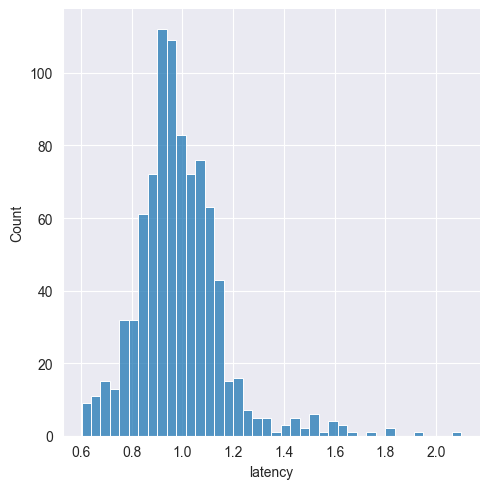

In [41]:
sns.displot(y_train)